In [67]:
# collect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!pip install transformers

In [69]:
import torch
import transformers
# per the setting of transformers, to use any of its NLP model
# we need to have three things: that is BertTokenizer, BertModel, BertConfig
from transformers import BertTokenizer, BertModel, BertConfig

In [70]:
# first, let's see if we have GPU so that we could train our model in GPU
# GPU is really at parallel computation
from torch import cuda
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(device)


cuda


In [71]:
# create an instance of BERT model 
# note that it takes time to download the BERT model (~ 440M)
# BERT model is big, because it has a lot of paramters. 
model = BertModel.from_pretrained('bert-base-uncased')

In [72]:
# creat an instance of BERT tokenizer
# as you can tell, the tokenizer is pretty small, only 232k in size
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [73]:
import pandas as pd
import numpy as np

url = 'stage_1_label_sample.csv'
raw_review = pd.read_csv(url)
raw_review

,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,social connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health
0,Crane Usa EE-5301 Cool Mist 2.3-Gallon Humidifier,Health & Personal Care,2,0,0,N,Y,If only it still worked....,"This product was great! for about a month, I l...",7/28/2012,0,0,0,0,0,0,0,0,0,1,0,0,0
1,"Medline Herringbone Cotton Dish Towels, 1 Dozen",Health & Personal Care,3,0,0,N,Y,Three Stars,The material isn't great. Doesn't dry hardly a...,12/16/2014,0,0,0,0,0,0,0,0,0,1,0,0,0
2,CytoSport Muscle Milk Snack Protein Bar,Health & Personal Care,4,0,0,N,Y,good,"This product tastes good, they are a bit small...",4/24/2013,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Toothco for ProResults,Health & Personal Care,5,0,0,N,N,Excellent,Excellent,8/6/2015,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Reynolds Consumer Products 1001090008031 Alumi...,Health & Personal Care,1,0,0,N,Y,Worst foil ever...,This foil is so thin that if a mosquito were t...,11/7/2013,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,Rocky Men's Thermal 2pc Set Long John Underwear…,Apparel,5,0,0,N,Y,Comfortable fit,Its a value for money purchase which basically...,11/24/2014,0,0,0,0,0,0,0,0,0,1,0,0,0
1657,Style J Indigo Elegance Long Denim Skirt,Apparel,5,0,0,N,Y,Great skirt,I really like this skirt. The front seam is a ...,3/9/2015,0,0,0,0,0,0,0,0,0,1,0,0,0
1658,Next Level Apparel Women's Terry Racerback Tank,Apparel,1,0,1,N,Y,Not worth it,Stiff fabric - not stretchy Tshirt material - ...,9/4/2014,0,0,0,0,0,1,0,0,0,1,0,0,0
1659,Playtex Women's Side Smoothing Underwire Bra,Apparel,3,0,0,N,Y,"Fits well, kind funky fabric","This bra fits well enough, definitely true to ...",9/18/2013,0,0,0,0,0,0,0,0,0,1,0,0,0


In [74]:
train_review = pd.DataFrame(None)

train_review[['text','label']] = raw_review[['review_body','thrift_value']]



In [75]:
train_review = train_review.dropna()

In [76]:
train_review.describe()

,label
count,1660.000000
mean,0.798795
std,0.401022
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


# Define a Customized Dataset Class and Setup the Dataloader



In [77]:
# first let's define some key parameters we will use later
# note this is a relatively large number, making the training process slow, 
# but it's necessary becuase a lot of reviews are long.
max_length = 128
# how many raw inputs we feed into the train and validation model at once
train_batch = 32
valid_batch = 32



In [78]:
# then we need to import the libraries we need
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [79]:
class YelpDataset(Dataset):

  # here we want to  create a customized dataset--YelpDataset--which could take a raw text as input
  # and encode it in BERT's way with a tokenizer. 
  # The tokenized input will be then fed into a BERT Model in the NN, which we will create later

  # __init__ defines some necessary attributes for any instance created
  # like: the dataset with raw text reviews, what tokenizer we want to use for encoding, 
  # the max length of sentence we need to pad or trancate
  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len
  

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    # __getitem__ take index as input, 
    # in general/without customizatin, it returns the sample with the index in the dataset
    # further we could customize its functionality, letting it to apply some operations on the 
    # index-specified sample before return a value for us
    # here we use index to locate a specific review text we want to pre-process
    # text = str(self.text[index])
    # text = " ".join(text.split())
    text = self.text.iloc[index]

    # then, we put the text into a BERT encode_plus
    # important debug tips: 
    # for encode_plus, to keep all the raw inputs in the same lenght
    # we need to specify BOTH padding and trancation in addition to max_length
    # the former for short sentences and the latter for long ones
    # failing to do either one will result in uneven lengths of encoded inputs,
    # which will create troubles for your dataloader in the nn training sessions
    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        # note that in some versions of transformer in you local machine, the code is 
        # pad_to_max_length = True,
        # truncation_strategy = 'longest_first',
        # we might need to change the argument name a little to fit different version of transformers
        add_special_tokens = True,
        return_tensors = 'pt'
    )
    # recall the BERT Tokenizer session, it takes raw text as input
    # and return input_ids, attention_mask
    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    # we then store those values and put them together with the label info in the sample
    # as the return of the __getitem__ method
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float) 
    }



In [80]:
# split the train and validate dataset
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(train_review, test_size = 0.1)

In [81]:
train_raw.label.value_counts()

1    1186
0     308
Name: label, dtype: int64

In [82]:
#extra_status_text_1 = pd.read_csv('status_augmented_3_5%.csv')
#extra_status_text_1.info()

#train_raw = pd.concat(([train_raw,extra_status_text_1]))
#train_raw.drop_duplicates(inplace=True)
train_raw.label.value_counts()

1    1186
0     308
Name: label, dtype: int64

In [83]:
# create instances of the YelpDataset for raw trianing and validate datasets
# recall that tokenizer has be defined by: tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') in the BERT tokenizer session
train_processed = YelpDataset(train_raw, tokenizer, max_length)
valid_processed = YelpDataset(valid_raw, tokenizer, max_length)

In [84]:
# check the attributes and method of train_processed
train_processed.__len__()

1494

In [85]:
# test the customized Dataset instance
print(train_processed.__getitem__(10))

{'input_ids': tensor([[  101,  2122,  2763,  4995,  1005,  1056,  2428,  2204,  2005,  2189,
          1012,  1045,  1005,  1049,  2025,  2019,  6739,  1010,  2021,  1045,
          2064,  5791,  2425,  1996,  4489,  2013,  2152,  2203,  2132, 19093,
          2013,  2122,  1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,
          1028,  2174,  1010,  1045,  4952,  2000,  2831,  2265,  2557,  2013,
          2026,  3526,  3042,  3262,  1010,  1998,  2005,  2008,  2027,  2147,
          6581,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [86]:
# see the dimension of the pre-processed data
print(train_processed.__getitem__(10)['input_ids'].shape)
# we can use the squeeze() method to remove the axis of "1", a method we will use later
print(train_processed.__getitem__(10)['input_ids'].squeeze().shape)

torch.Size([1, 128])
torch.Size([128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [87]:
# important, run it again to create a new dataset loader for every NN model you train
# lastly, set up the dataloader that serves as a pipeline feeding pre-processed data into the neural network
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, batch_size = valid_batch, num_workers = 0)

In [88]:
# exploer the attributes of dataloder
# length of dataloader = len(dataset)/batch size
print(len(train_loader))
print(len(valid_loader))


47
6


# Define a Customized Neural Network with the First Hidden Layer as NLP Encoding Layer


Up to now, we have defined the customized Dataset class that preprocess the raw input, encoding them into input_ids and attention_mask that BERT model needs. We also set up the Dataloader that feed the pre-processed data into the Neural Network we are creating now. 

In [89]:
# import the functions we need use in the Netwrok Model
import torch.nn.functional as F

In [90]:
# the neural network we create is a class called  YelpBERT, which inherits
# the attributes and structures of the torch.nn.Module

# the __init__ functino defines the necessary hidden layers of the NN
# and the forward function set up the computation graph: the real calculation procedures of the NN
# see the class session 7's slides and recording for details 

class YelpBERT(torch.nn.Module):
  def __init__(self):
    super(YelpBERT, self).__init__()
    # recall that, we have defined model as: model = BertModel.from_pretrained('bert-base-uncased')
    # see BERT Model's input and output: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    self.l1 = model

    # with this layer a percentage of all neurons will be randomly turned-off to prevent overfitting
    # since our training dataset might be small, we really cannot afford a large neural network
    # the output of the BERT layer is a vector of 768 elements, if fully connected to next linear layer
    # then the current layer would have 768 neurons, too much! 
    # using dropout mechanism, we can randomly turn off a percentage of the neuraon in the training process
    # literally reduced the number of neuron in the layer
    self.l2 = torch.nn.Dropout(0.4) 

    # if you want to have multiple fully connected linear layer, use this
    # self.l2 = torch.nn.Linear(768, 10)
    # but again, if your training dataset is not very large, we may only offard one linear layer
    
    # last layer
    self.l3 = torch.nn.Linear(768, 1)


  
  def forward(self, input_ids, attention_mask):
    # first layer
    # the first layer utilize the BERT model (call "model" in __init__) to transfer the input_ids into
    # contextualized word embeddings --numerical vectors
    # we can customize the output of this layer such as using the [CLS] token or the mean of all input tokens
   
    # if you want to use the BERT output of the last self-attention layer, use this:
    last, pooler = self.l1(input_ids = input_ids, attention_mask = attention_mask)
   
    # if you want to use BERT output from OTHER self-attention layers,use this:
    # (note that BERT base model has 12 hidden self-attention layers), 
    # last, pooler, all = self.l1(input_ids = input_ids, attention_mask = attention_mask, output_hidden_states = True)
    
    # second layer
    # here we could use the mean value of tokens of all raw inputs as the embedding of the whole input text
    # and feed it into the second layer, use this: 
    # output from last BERT self-attention layer:
    # initial index "0" for mean value of [cls] token and all non-padded tokens
    # initial index "1" for mean value of all non-padded tokens only
    output = last[:, 0 : attention_mask.sum(), :].mean(dim = 1)
    # BERT output from other hidden self-attention layer:
    # output = all[11][:, 0 : attention_mask.sum(), :].mean(dim = 1)
    
    # or use the [CLS] token of last layer
    # output = last[:, 0, :]

    # output from BERT model now be fed into a relu activation funcation adn
    # the second layer of the Neural Network
    output = F.relu(output.squeeze())
    output = F.relu(self.l2(output))

    # why squeeze(): to make the dimension of input-output across layers consistent
    # e.g., the output of layer 1--self.l1, is in the shape of (1, 768),
    # we use .squeeze() to make it in a shape of (768) only, 
    # because the later layer--l2 adn l2--take (768) as input dimension not (1, 768)

    # third layer
    output = self.l3(output)

    # last sigmoid layer to furhter transfer the single scalar of l3 into a probability
    return torch.sigmoid(output)
    # note that we can also customize the layers after the 1st one, 
    # making more layers (i.e., a deeper NN) and see if it perform betters 

In [91]:
# test the model step-by-step
# compare the output dimension to your expectation
# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
# testing each layer in the NN is very important
# we should pay close attention the the dimensions of the inputs and outputs of each layer 
# use .squeeze() to remove uncessary axis whose length is 1 to make the dimensions consistent. like "output = pooler.squeeze()" in the NN above
l1 = model
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last, pooler = l1(input_ids = input_ids, attention_mask = attention_mask)
print(last.shape)
print(last.squeeze().shape)
print(pooler.shape)
print(pooler.squeeze().shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 128, 768])
torch.Size([128, 768])
torch.Size([1, 768])
torch.Size([768])


In [92]:
# similarly, test if the dimensions of input and output 
output = last[:, 1 : attention_mask.sum(), :].mean(dim = 1)
output = output.squeeze()
output.shape
l2 = torch.nn.Dropout(0.4)   
l2.to(device)
l3 = torch.nn.Linear(768, 1)
l3.to(device)
output.to(device)
l3(l2(torch.tensor(output)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


tensor([-0.3116], device='cuda:0', grad_fn=<AddBackward0>)

# Create a BERT + NN Model as an Instance of the Customized Model Classs Defined Above and Setup the Loss Function and Optimizer


In [93]:
# create an instance of the YelpBERT model
# remember to recreat a instance of the Model Class after you modified the YelpBERT class
model_yelp = YelpBERT()
model_yelp.to(device)

YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [94]:
# test the model_yelp
# recall that the train_processed is a special class that could pre-process the raw input words into input_ids
# and attentino_mask using its method __getitem__ method
# we then use this method to get the input_ids and attention_mask that we need to feed in the YelpBERT() model

test_output = model_yelp(input_ids, attention_mask)
print(len(test_output))
print(test_output)
# note that the output is a scalar, becasue ofthe last hidden layer in the NN, self.l3 = torch.nn.Linear(768, 1)
# the scalar then can be put into a softmax for prediction 


1
tensor([0.5382], device='cuda:0', grad_fn=<SigmoidBackward>)


In [95]:
print(input_ids.shape)
print(attention_mask.shape)


torch.Size([1, 128])
torch.Size([1, 128])


In [96]:
# check out the model parameters
# note that the first BERT layer, the word embeddings are in the shape of (30522, 768)
# and we can tell that the first 12 layers of our model are normal BERT layers, 
# the last two are what we customized-- a dropout layer and the linear layer
model_yelp.parameters

<bound method Module.parameters of YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Up to now, we have the Dataset (pre-process/encode the raw text inputs, making them into input_ids that BERT model takes as input), the Dataloader (feed the processed data into the NN in batchs), the neural network (with the first layer as a BERT model, the transfer the encoded input_ids into word embeddings, and later layers just work on those embeddings/numerical vectors as normal neural network). 

And finally, we could set up our training loops

First we start with: the loss function (e.g., crossentropy loss or mean squared error loss) and the optimize schedule (some thing about learning rate, adaptive learning rate, see class 7)

In [97]:
import torch.nn as nn
import torch.optim as optim

In [98]:
# criterion is the loss function we use
# here we use Binary CrossEntropy Loss, you can try others see the performance difference
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = nn.BCELoss()
# note that loss function in pytorch framework usually take the pair of (prediction, ground_truth) as input
# and give the loss value as output

In [99]:
# optimizer is our optimize strategy, here we use stachastic gradient descending as the approch 
# to update our model parameters. 
# tips: previously I trained multiple models but with learning rate = 1e-05, 3e-05, 
# after 4 epochs the model performance almost doesn't change
# thus now I use 10e-05, it seems the performance improves faster
learning_rate = 10e-05
# SGD is a common optimizer, but let's use Adam here, AdamW is a optimizer developed by Huggingface using Adam's mechanism
# optimizer = optim.SGD(model_yelp.parameters(), lr = learning_rate, momentum = 0.9)
# http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
# you can try out other optimization method and see performance difference

In [100]:
# set the epoch
epochs = 5
# epochs means how many rounds each training sample will be fed into the NN.
# next, we need to supply our model "model_yelp" to the GPU, so it can be run on GPU
# model_yelp.to(device)
# since the GPU has a lot of cores, it takes some time to supply to model to the GPU


In [101]:
# try another optimizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_yelp.parameters(),lr = learning_rate,eps = 1e-8)
                  
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler that update the learning rate gradully, this scheduler is with AdamW
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [102]:
# lastly, let's define a helper function we can use for calculating the prediction accuracy
import numpy as np
# the idea of the funtion is that a vector of predicted probablity of being good review, 
# which is the output of the sigmoid/last layer of the neural network, is compared with the true label
# is the predicted probability >= 0.5, we assign 1, otherwise we assign 0, we use np.around() achieve this
def pred_accuracy (prediction, label):
  pred_flat = np.around(prediction).flatten()
  label_flat = label.flatten()
  return np.sum(pred_flat == label_flat) / len(label_flat)


# Train the BERT + NN Model and Evaluate the Performance

In [103]:
# set the random set the same, making the results reproducible
import random
seed_val = 49
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

OK, finally, we strat to train the model

In [104]:
# create an instance of the YelpBERT model
model_yelp = YelpBERT()
model_yelp.to(device)

YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [105]:
# set up the directory for storing the trained model
import os
# save to Google Drive
dir = "/content/drive/My Drive"
# save to local file
# dir = "E://OneDrive - lmu.edu//Python Projects//BERT and ML"


In [106]:
# Very Important: Each Time When You Train a Neural Network Again, 
# Plase recreate the nural network, the dataloader, and the optimizer and its scheduler.


# train the model 
# store the total loss and accuracy values of each epoch
training_stats = []

# the epoch loop, number of rounds specified by epochs
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))
  # zero the values of total loss and accuracy of the epoch
  total_loss = 0
  total_accuracy = 0
  # in the training stage, set the model into train mode
  model_yelp.train()

  # the training step loop
  # recall that train_loader feed data into the NN in batchs to save memory and improve efficiency
  # then the # of total steps is about (# of samples/batch size)
  print("training")
  for step, batch in enumerate(train_loader, 0):
    # feed the data into GPU using .to(device) method
    # note that the input_ids for one raw input is in the shape of (1, max_length)
    # after be processed into batch, the input_ids become (batch_size, 1, max_length)
    # however, BERT only takes input_ids in the shape of (batch_size, max_length),
    # (see here: https://huggingface.co/transformers/model_doc/bert.html#bertmodel)
    # so we need to do "batch['input_ids'].squeeze()" inestead of "batch['input_ids']"
    # to remove the unnecessy axis of "1". 
    # same operation for attention_mask
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    # at each step, before the NN does the feed forward, let's set the gradient to 0
    # as pytorch nn.Module automatically cumulates gradient from previous rounds
    # this is good for RNN training, but not necessy for us here. Thus, we turn it off.   
    optimizer.zero_grad()
    
    # for each raw input, the feed forward calculation give us two scalar, 
    # representing the score/probability of the sample being 0/bad review class or 1/good review class  
    # note that since we feed the inputs/raw samples in batch, 
    # the prediciton should be in the shape of (batch_size, # of classes)
    prediction = model_yelp(input_ids, attention_mask)
    prediction = prediction.squeeze()

    # criterion is defined as a cross entropy loss function
    # it takes (prediction, ground truth) as input arugments
    # the former should be in the shape of (batch_size, # of classes), 
    # the latter should be in the sahpe of (batch_szie, 1), "1" dimension records the true class id of the input
    # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html   
    loss = criterion(prediction, label)

    # with the loss, we can do back propagation to calculate the gradient
    # very easy, just one line of code  
    loss.backward()

    # with the gradient, we can update the model paramters. 
    # recall how we define the optimizer in the above cell  
    optimizer.step()
    
    # update the learning rate
    scheduler.step()

    # to keep tracking on the model performance, we accumulate the total loss in every epoch  
    total_loss += loss.item()
      
    # for every 10 steps, we print out the epoce # and loss
    # again, the max_length of raw text input is 256, relatively long than usual, thus it will take longer to train. 
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')
  
  # calcualte and store the average training loss of each batch in the current epoch
  avg_train_loss = total_loss / len(train_loader)

  

  # now let's set up the validation loop, meaning the trained model above will be used to evaluate the sample in validation dataset
  # note that this validation loop is in the same "indent" level as the training loop, and they both under the epoches loop
  print("validating")
  # set the model now in the evaluation mode
  model_yelp.eval()
  # zero the values of total loss and accuracy
  total_loss = 0
  #total_accuracy = 0

  # validation loop
  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = model_yelp(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )
  


  # lastly, at the end of each epoch, let's save the model for later use
  # note that dir is defined before as "./content/drive/My Drive"  
  torch.save(model_yelp.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")



======== Epoch 1 / 5 ==========
training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1, Total_Loss:5.539227485656738, Average_Loss:0.5539227485656738
Epoch:1, Total_Loss:10.457455068826675, Average_Loss:0.5228727534413338
Epoch:1, Total_Loss:14.550578191876411, Average_Loss:0.48501927306254705
Epoch:1, Total_Loss:20.028997138142586, Average_Loss:0.5007249284535646
validating
======== Epoch 2 / 5 ==========
training
Epoch:2, Total_Loss:4.831211805343628, Average_Loss:0.4831211805343628
Epoch:2, Total_Loss:9.005742728710175, Average_Loss:0.4502871364355087
Epoch:2, Total_Loss:12.540767699480057, Average_Loss:0.41802558998266853
Epoch:2, Total_Loss:17.611664950847626, Average_Loss:0.44029162377119063
validating
======== Epoch 3 / 5 ==========
training
Epoch:3, Total_Loss:3.8667531609535217, Average_Loss:0.38667531609535216
Epoch:3, Total_Loss:6.743477404117584, Average_Loss:0.3371738702058792
Epoch:3, Total_Loss:9.679795905947685, Average_Loss:0.3226598635315895
Epoch:3, Total_Loss:12.9812650680542, Average_Loss:0.324531626701355
validating
======== Epoch 4 / 5 ====

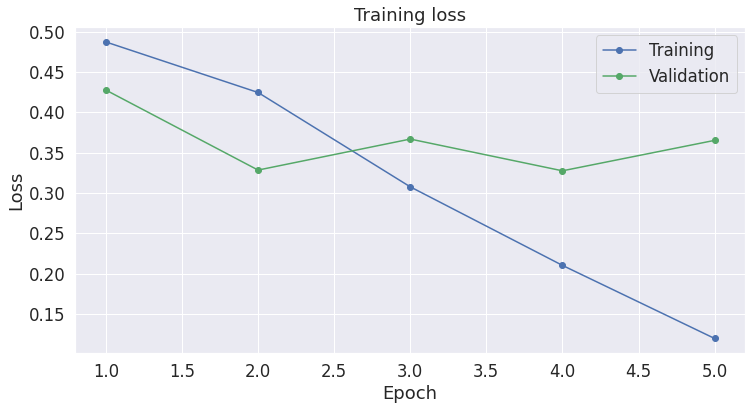

In [107]:
# plot the train statistics stored in training_stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [108]:
df_stats['Valid. Loss']

epoch
1    0.427512
2    0.328287
3    0.366736
4    0.327375
5    0.365130
Name: Valid. Loss, dtype: float64

In [109]:
# make sure to save the model performance statistics and the associated model configuration. 
# that is save the df_stats to csv file with a file name, say experiment 1
df_stats.to_csv(os.path.join(dir, 'label_experiment_4.csv'))
# save the key hyper-parameters of this training experiment, say experiment 1
label_experiment_4_config = {
    "epochs": epochs,
    "train_batch_size" : train_batch,
    "valid_batch_size" : valid_batch,
    "initial_learning_rate": learning_rate,
     "max_sentence_length": max_length,
     "loss_fucntion": criterion,
     "optimizer": optimizer,
     # you need to manually type-in the following info
     "BERT output": "mean value of [cls] embeddings of non-padded token from the second to the last layer",
     "activation function": "relu",
     "dropout rate of BERT output": model_yelp.l2,
     "# of fully connected linear layer": 1,
     "dataset": "Yelp Review Balanced",
     "comment": "sees not as good as the outputs of last layer"
}


In [110]:
# save the experiment configurate assocaited with this experiment
# note that if you click the file icon (the third vertical one on the far left)
# you will see the save files, double click on them, you can see them.
import csv
with open(os.path.join(dir, 'label_experiment_4_config.csv'), 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in label_experiment_4_config.items():
       writer.writerow([key, value])

# Evaluate the Model Performance

In [111]:
# apply the trained model to the validation dataset
# get the model predictions and compare the comparisons to the true labels
model_yelp.eval()
predictions, labels = [], []

for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    prediction = model_yelp(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [112]:
# call the helper function-- pred_accuacy to compute the prediction accuracy in each batch
ac = []
for i in range(len(predictions)):
  ac_i = pred_accuracy(predictions[i], labels[i])
  ac.append(ac_i)
ac

[0.875, 0.96875, 0.75, 0.84375, 0.90625, 1.0]

In [113]:
# transfer the outcomes into np
predictions = np.asarray(predictions)
labels = np.asarray(labels)
predictions[0]
# note that now the outcomes are still stored in batches

array([[0.97412574],
       [0.9847233 ],
       [0.98660463],
       [0.9850299 ],
       [0.9849054 ],
       [0.98677886],
       [0.986524  ],
       [0.9827078 ],
       [0.9856011 ],
       [0.9828683 ],
       [0.9631385 ],
       [0.98386186],
       [0.9780397 ],
       [0.9867149 ],
       [0.8489428 ],
       [0.9860284 ],
       [0.98111236],
       [0.02016047],
       [0.9858723 ],
       [0.96207875],
       [0.8906621 ],
       [0.9842704 ],
       [0.9673303 ],
       [0.02819719],
       [0.9016832 ],
       [0.98631734],
       [0.9660889 ],
       [0.040386  ],
       [0.9720443 ],
       [0.97972095],
       [0.02336227],
       [0.98564595]], dtype=float32)

In [114]:
# convert predictions stored in allrevithe batches into a long vector
pred = np.concatenate(predictions, axis=0 )
pred = np.concatenate(pred, axis=0 )
pred = pred.reshape(len(pred),1)
print(pred.shape)

(166, 1)


In [115]:
# convert the true labels batches into a long vector
true_label = np.concatenate(labels, axis=0 )
true_label = true_label.reshape(len(true_label), 1)
print(true_label.shape)
type(true_label)

(166, 1)


numpy.ndarray

In [116]:
# put the predictions and labels into the same dataset
df = np.concatenate([pred, true_label], axis = 1)
df = pd.DataFrame(data=df, columns=["preds", "labels"])
df

,preds,labels
0,0.974126,1.0
1,0.984723,1.0
2,0.986605,1.0
3,0.985030,1.0
4,0.984905,0.0
...,...,...
161,0.983622,1.0
162,0.979732,1.0
163,0.986397,1.0
164,0.978072,1.0


In [117]:
df.labels.value_counts()

1.0    140
0.0     26
Name: labels, dtype: int64

In [118]:
# see the total prediction accuracy
sum((df["preds"]>=0.5) == df["labels"])

145

In [119]:
# find the index of the review that has the lowest predicted probabilty(of being a positive review) in true_label == 1 group. 
df.loc[df.loc[df['labels'] == 1, :].idxmin()]

,preds,labels
17,0.020160,1.0
0,0.974126,1.0


In [120]:
# see that review
valid_raw.iloc[14,0]


'Question,<br /><br />I read all these complaints about the company and the software. Why does Amazon still let this company sell products through the Amazon Marketplace with so many angry customers? Also, the product KeyGrabber USB KeyLogger 8MB Black is a piece of junk and does not work. If and when it does work, it does not capture the data from the keyboard that you need. Many online banking sites somehow block this device from capturing anything. I checked with my bank, I was told because of the way the site is coded, the device will not work. Since IE9 does not save my username and password either, everything on the market for this industry is dead. With so much technology out, it is really amazing the United States has no more people / programmers / developers / computer engineers with any brains left.'

In [121]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df.loc[df['labels'] == 0, :].sort_values(by='preds',ascending = False)

,preds,labels
107,0.986649,0.0
8,0.985601,0.0
4,0.984905,0.0
108,0.982969,0.0
149,0.981484,0.0
12,0.978040,0.0
94,0.972644,0.0
104,0.969228,0.0
87,0.957225,0.0
93,0.935809,0.0


In [122]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
17,0.020160,1.0
86,0.020953,1.0
72,0.032658,1.0
97,0.039149,1.0
99,0.071702,1.0
...,...,...
114,0.986613,1.0
56,0.986619,1.0
132,0.986714,1.0
13,0.986715,1.0


In [123]:
df[df['labels']==1].preds.sort_values()[0:20]

17     0.020160
86     0.020953
72     0.032658
97     0.039149
99     0.071702
128    0.323646
156    0.403950
55     0.604213
69     0.636072
138    0.636958
146    0.652333
35     0.710022
41     0.794151
151    0.803047
118    0.807788
14     0.848943
79     0.849551
20     0.890662
24     0.901683
110    0.911995
Name: preds, dtype: float32

In [124]:
# see the reviews
valid_raw.iloc[48,0]

'This is a great shower unit, but I too was surprised that the key parts were plastic.The plastic fitting that attached the unit to the pipe in the wall felt like the threads stripped when I was tightening it. I added more teflon tape and tried again more gently, and so far it has not leaked. Be careful not to over-tighten the plastic fitting. The hose is much stiffer than my previous shower unit, so it is harder to get it to stay out of the way.Otherwise, the unit has performed well and is very attractive.'

In [125]:
# on the other way around, for all the reviews whose label == 0, 
# let's sort their predicted probablities in descending order
df[df['labels'] == 0].sort_values('preds', ascending = False)

,preds,labels
107,0.986649,0.0
8,0.985601,0.0
4,0.984905,0.0
108,0.982969,0.0
149,0.981484,0.0
12,0.978040,0.0
94,0.972644,0.0
104,0.969228,0.0
87,0.957225,0.0
93,0.935809,0.0


In [126]:
# see the reviews
# after learning some examples, it seems that our model will give a high score as long as the food is good
# even though the service is not. 
valid_raw.iloc[140,0]

"I was hesitant to buy Turbo this year after having left to buy TaxCut last year when Intuit had the arrogance to put spyware into their product and add a disturbing activation process. I had always been a Turbo user but was so incensed at last years shenanigans by Intuit that I switched to TaxCut (and would do so again, should they initiate the same nonsense as they did in 2002). In any case, TaxCut in not even remotely as user friendly or robust as Turbo and given the opportunity to have Turbo as it was in 2001 and prior I have gladly come back. After reading the reviews on Amazon I hesitated, but am glad I gave it a try. The installation (on a Win 98 machine)was flawless (except for a minor glitch of it crashing my system when updating the software the first time). Useability is as good as always, in my opinion, which as I've said is light years ahead of TaxCut. In light of the options available on the market, Turbo is the clear choice (unless you want to suffer with a lesser produc

In [127]:
df['pred_label']=0
df['pred_label'][df['preds']>0.5]=1
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,preds,labels,pred_label
0,0.974126,1.0,1
1,0.984723,1.0,1
2,0.986605,1.0,1
3,0.985030,1.0,1
4,0.984905,0.0,1
...,...,...,...
161,0.983622,1.0,1
162,0.979732,1.0,1
163,0.986397,1.0,1
164,0.978072,1.0,1


In [128]:
df['preds'].sort_values(ascending=False)[0:20]

5      0.986779
13     0.986715
132    0.986714
107    0.986649
56     0.986619
114    0.986613
153    0.986605
2      0.986605
137    0.986577
47     0.986554
6      0.986524
98     0.986501
64     0.986481
121    0.986447
150    0.986417
163    0.986397
25     0.986317
85     0.986227
116    0.986214
117    0.986184
Name: preds, dtype: float32

In [129]:
df['pred_label']

0      1
1      1
2      1
3      1
4      1
      ..
161    1
162    1
163    1
164    1
165    0
Name: pred_label, Length: 166, dtype: int64

In [130]:
len(df['labels']) == len(df['pred_label'])

True

[[ 12  14]
 [  7 133]]
Precision is  0.9047619047619048  , Recall is  0.95
built-in f1 score is  0.9268292682926829
Accuracy score is  0.8734939759036144
AUC score is  0.8008241758241759


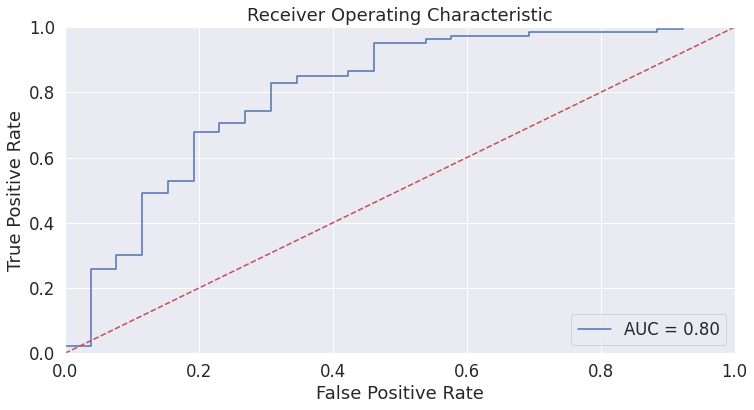

In [131]:
import sklearn

#Confusion Matrix
confusion_matrix_census=sklearn.metrics.confusion_matrix(df['labels'], df['pred_label'], labels=None, sample_weight=None, normalize=None)
tn, fp, fn, tp = confusion_matrix_census.ravel()
print(confusion_matrix_census)

#Precision and Recall
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print('Precision is ',precision,' , Recall is ',recall)


#f1 score
from sklearn.metrics import precision_recall_fscore_support
f1_score_cen=sklearn.metrics.f1_score(df['labels'], df['pred_label'],average='binary')
print('built-in f1 score is ',f1_score_cen)


#Accuracy score and AUC score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df['labels'], df['pred_label'])
print('Accuracy score is ',accuracy)

fpr, tpr, threshold = metrics.roc_curve(df['labels'], df['preds'])
roc_auc = metrics.auc(fpr, tpr)
print('AUC score is ',roc_auc)

#drae the graph
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Predict on the colleted data**

In [132]:
all_review = pd.read_csv('all_reviews_v4.0.csv')

new_review = pd.DataFrame(None)

#take a small sample for now
new_review = all_review

new_review['label']= 0

new_raw = new_review.dropna(subset=['text'])

new_raw

,Unnamed: 0,index,asin,productTitle,countReviews,date,imageUrlList,numberOfHelpful,parentReviewId,rating,reviewId,text,title,username,category,label
0,0,1,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/16/2020,NaN,0,NaN,3,R385E1LP3AE40R,This Columbia jacket is a pretty good quality ...,Pretty good rain jacket,June B Furr,apparel,0
1,1,2,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/15/2020,NaN,0,NaN,5,R36I6DUHDK4HIB,Just as expected! Perfect rain jacket for todd...,Toddler approved,Meeko0924,apparel,0
2,2,3,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/14/2020,NaN,0,NaN,4,R4YTDBV1VENF6,I bought this for a Birthday gift and haven't ...,Birthday gift,Vera T.,apparel,0
3,3,4,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/11/2020,NaN,0,NaN,5,RMQ5B577OTPJY,This is perfect for those fall and spring days...,Good jacket,RD,apparel,0
4,4,5,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/10/2020,NaN,0,NaN,5,R12IYTDMAX94FD,good color,very good,ivy,apparel,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134961,135795,135796,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,11/6/2018,NaN,5,NaN,3,R1IP5E8DS9YEP3,UPDATE 11/23/2018: I'm dropping the rating a s...,"Excellent Value, Potential Alternative to Phot...",Amazon Customer,software,0
134962,135796,135797,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,11/5/2018,NaN,12,NaN,4,R2AVKQCZXW4IGN,"PaintShop Pro 2019 comes in a box with a DVD, ...",A Quirky but Reasonable Application for Image ...,Jeffrey N. Fritz,software,0
134963,135797,135798,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,10/31/2018,NaN,3,NaN,4,R1YTIJIGJ4IMT7,I see by the reviews that a LOT of folks had p...,Some times you eat the bear and sometimes...,enubrius,software,0
134964,135798,135799,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,10/30/2018,NaN,4,NaN,3,R3FO4N6RUDI1EY,I had the disc and still experienced installat...,Paintshop Pro 2019 Ultimate - Photo with Multi...,new yorker,software,0


In [133]:
# apply the trained model to the NEW dataset
# get the model predictions

predictions_new, labels_new = [], []

new_processed = YelpDataset(new_raw, tokenizer, max_length)

new_loader = DataLoader(new_processed, batch_size = valid_batch, num_workers = 0)


for step, batch in enumerate(new_loader):
  input_ids_new = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask_new = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label_new = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    new_prediction = model_yelp(input_ids_new, attention_mask_new)

  new_prediction = new_prediction.detach().cpu().numpy()
  predictions_new.append(new_prediction)
  labels_new.append(label_new)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
predictions_new

In [ ]:
# call the helper function-- pred_accuacy to compute the prediction accuracy in each batch
ac_new = []
for i in range(len(predictions_new)):
  ac_i = pred_accuracy(predictions_new[i], labels_new[i])
  ac_new.append(ac_i)
ac_new

In [ ]:
# transfer the outcomes into np
predictions_new = np.asarray(predictions_new)
labels_new = np.asarray(labels_new)
predictions_new[0]
# note that now the outcomes are still stored in batches

In [136]:
# convert predictions stored in the batches into a long vector
pred_new = np.concatenate(predictions_new, axis=0 )
pred_new = np.concatenate(pred_new, axis=0 )
pred_new = pred_new.reshape(len(pred_new),1)
print(pred_new.shape)

(134966, 1)


In [137]:
# convert the true labels batches into a long vector
true_label_new = np.concatenate(labels_new, axis=0 )
true_label_new = true_label_new.reshape(len(true_label_new), 1)
print(true_label_new.shape)
type(true_label_new)

(134966, 1)


numpy.ndarray

In [ ]:
# put the predictions and labels into the same dataset
df_new = np.concatenate([pred_new, true_label_new], axis = 1)
df_new = pd.DataFrame(data=df_new, columns=["preds", "labels"])
df_new

In [ ]:
df_new

,preds,labels
0,0.987033,0.0
1,0.009132,0.0
2,0.009905,0.0
3,0.009620,0.0
4,0.010506,0.0
...,...,...
135795,0.983766,0.0
135796,0.041913,0.0
135797,0.013055,0.0
135798,0.987761,0.0


In [ ]:
# see the total prediction accuracy
#sum((df["preds"]>=0.5) == df["labels"])

In [ ]:
# find the index of the review that has the lowest predicted probabilty(of being a positive review) in true_label == 1 group. 
df.loc[df.loc[df['labels'] == 0, :].idxmin()]

In [ ]:
# see that review
valid_raw.iloc[0,0]


In [ ]:
df_new['label']= df_new['preds']>0.5
df_new['label'] = df_new['label'].replace({True:1,False:0})
df_new

In [ ]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df_new.loc[df_new['label'] == 0, :].sort_values('preds')

In [ ]:
new_raw.iloc[3045,0]

In [ ]:
df_new.loc[df_new['label'] == 1, :].sort_values('preds',ascending = False)

In [ ]:
new_raw.iloc[14763,0]

In [140]:
new_raw.reviewId.nunique()

134966

In [ ]:
new_raw

In [ ]:
new_raw['thrift_pred'] = df_new['preds']
new_raw

In [ ]:
new_raw['helfulness'] = all_review['numberOfHelpful']

new_raw['rating'] = all_review['rating']

new_raw

In [143]:
new_raw = new_raw.set_index('reviewId')

In [ ]:
new_raw

In [156]:
#join to the final dataset

final = pd.read_csv('all_values_predicted.csv')

In [157]:
final.thrift_pred.value_counts()

0.205241    656
0.193674    489
0.309197    398
0.707394    313
0.583936    275
           ... 
0.182645      1
0.088778      1
0.954908      1
0.989817      1
0.814341      1
Name: thrift_pred, Length: 90743, dtype: int64

In [158]:
final = final.set_index('reviewId')

In [ ]:
final

In [159]:
final['thrift_pred'] = new_raw['thrift_pred']

In [160]:
final.thrift_pred.value_counts()

0.530585    684
0.567157    505
0.438953    408
0.228029    329
0.984015    286
           ... 
0.689120      1
0.981583      1
0.029348      1
0.939125      1
0.023438      1
Name: thrift_pred, Length: 90307, dtype: int64

In [161]:
final.to_csv('all_values_predicted_v2.0.csv')

In [ ]:
new_raw.to_csv('all_reviews_predicted_numbers_status.csv')

In [ ]:
new_raw.groupby('label').mean()

# **Save and Load a Trained Model**

In [ ]:
# check the tutorial here:
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

# if you want to save the trained model for later evaluation (not for training)
dir = "/content/drive/My Drive/" 
torch.save(model_yelp.state_dict(), os.path.join(dir, 'status_model.pt'))

# later if you want to load the model and use it for evaluation (not trianing), do this: 
# the_model = TheModelClass(*args, **kwargs), in our case
#new_model = YelpBERT()

# and the_model.load_state_dict(torch.load(PATH)), note that path is specified above
#new_model.load_state_dict(torch.load(path to the save model))


# **BERT Enconding and Cluster Analysis**

Up to now we have been focusing on using BERT to generate a contextulized embedding for the raw input reviews, then feeding the sentence embeddings into a neural network for classification. The classification analysis helps us to check if the review has some attributes (i.e.,positive or negative, manifiest some customer values or not) and to what extent the review has those attributes (i.e., the predicted probablity)

Now, let's think about another use of the contextualized sentence embedding. We can do cluster analysis on those embeddings and see if there are some patterns in it. We can do it by locations (RMDS group's location-specific Yelp review analysis), product categories (RPA group's category-specific analysis), years (RPA group's time series analysi), and review type (e.g., positive vs. negative).

By dong so, we can learn the representative reviews, keywords, opinions in each cluster, and by comparing the clusters derived from differnt locations, product categories, years, and review types. We can obtain a lot of insights!

In [ ]:
#don't predict, just import

new_raw = pd.read_csv('all_reviews_predicted_status.csv')

new_raw

,Unnamed: 0,text,date,category,label,helfulness,rating
0,0,This Columbia jacket is a pretty good quality ...,7/16/2020,apparel,1,0,3
1,1,Just as expected! Perfect rain jacket for todd...,7/15/2020,apparel,0,0,5
2,2,I bought this for a Birthday gift and haven't ...,7/14/2020,apparel,0,0,4
3,3,This is perfect for those fall and spring days...,7/11/2020,apparel,0,0,5
4,4,good color,7/10/2020,apparel,0,0,5
...,...,...,...,...,...,...,...
135795,135795,UPDATE 11/23/2018: I'm dropping the rating a s...,11/6/2018,software,1,5,3
135796,135796,"PaintShop Pro 2019 comes in a box with a DVD, ...",11/5/2018,software,1,12,4
135797,135797,I see by the reviews that a LOT of folks had p...,10/31/2018,software,0,3,4
135798,135798,I had the disc and still experienced installat...,10/30/2018,software,1,4,3


In [ ]:
# to do cluster analysis, we first need to transfer the raw text review into embeddings
# we can leverage our trianed NN model to do so. 
# Recall thate the first layer in our NN is a BERT model, whose job is exactly this. 
# one benefit of using our traind NN rather than a commnon instance of raw BERT Model 
# is that in our trained model, the BERT layer is also updated, its parameters 
# has be trained to understand our general context (e.g., Yelp or Amazon reviews)
# and thus can encode our text better.

# then, our job is to feed the raw text into our trained NN. 
# However, the final output of  our NN is a predicted probability
# we thus need to extract the intermediate output of the NN, i.e., the output of its first layer, the BERT layer
# here is a built-in function in Pytorch, call hook, to do the job-- extracting a NN's intermediate output

# bascially, hook is just a mark attached to a specific NN layer, 
# telling the NN to store the intermediate output for later use
# here, we store the intermediate output in inter_out

inter_output = {}
def get_inter_output(name):
    def hook(model, input, output):
        inter_output[name] = output[0].detach()
    return hook

handle = model_yelp.l1.register_forward_hook(get_inter_output('l1'))


In [ ]:
model_yelp(input_ids,attention_mask)

tensor([0.5312], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
handle.remove()

In [ ]:
len(inter_output)

1

In [ ]:
inter_output['l1'].shape

torch.Size([1, 128, 768])

In [ ]:
model_test = YelpBERT()
model_test.to(device)

YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
handle.remove()

In [ ]:
inter_output["l1"][:, 0 : attention_mask.sum(), :].mean(dim = 1).shape

torch.Size([1, 768])

In [ ]:
model_yelp.named_modules()

<generator object Module.named_modules at 0x7f0233521af0>

In [ ]:
# first, let's convert the raw review texts into contextualized numerical embeddings 
# using encode_plus and BERT model

def text_to_embedding(index, dataset, max_len):
  # argument input: is the index to locate a specific text reivew
  # argument dataset: is the dataset that containing text reviews
  # argument max_len: is the max length of each review, for padding or truncating 
  
  # extract the review text column in the dataset
  # per my experience, extract a column and then using pd.iloc[index] on the column
  # experience less bugs than pd.loc[index, 'column name']
  reviews = dataset.text

  # get the text review
  text = reviews.iloc[index]
  # transfer the text reivew into input_ids and attentino_mask that are required for BERT model
  encoded_text = tokenizer.encode_plus(
      text,
      max_length = max_len,
      # note that in some versions of transformer in you local machine, the code is 
      # pad_to_max_length = True,
      # truncation_strategy = 'longest_first',
      # we might need to change the argument name a little to fit different version of transformers
      padding = "max_length",
      truncation = "longest_first",
      add_special_tokens = True,
      return_tensors = "pt"
  )
  # make the input_ids and attention_mask into torch tensors, 
  # which will make the late use of BERT Model easier
  # note that we use to(device) to deliever the data to GPU, 
  # so that they can be used in model_yelp, which is alread in GPU
  input_ids = torch.tensor(encoded_text['input_ids'], dtype = torch.long).to(device)
  attention_mask = torch.tensor(encoded_text['attention_mask'], dtype = torch.long).to(device)
  
  # transfer the input_ids and attention_mask into sentence embeddings by
  # putting them into our trained NN model: mddel_yelp
  model_yelp(input_ids, attention_mask)
 
  
  text_embedding = inter_output["l1"][:, 0 : attention_mask.sum(), :].mean(dim = 1)
  # again, we can choose to use differnt outputs from the BERT Model as the embeddings of the sentence/review
  # here, we use the mean value of non-padded tokens from the last self-attention layer of BERT  
  
  return text_embedding



In [ ]:
new_raw

In [ ]:
label_review = new_raw[['text','label']]
label_review

,text,label
0,This Columbia jacket is a pretty good quality ...,1
1,Just as expected! Perfect rain jacket for todd...,0
2,I bought this for a Birthday gift and haven't ...,0
3,This is perfect for those fall and spring days...,0
4,good color,0
...,...,...
135795,UPDATE 11/23/2018: I'm dropping the rating a s...,1
135796,"PaintShop Pro 2019 comes in a box with a DVD, ...",1
135797,I see by the reviews that a LOT of folks had p...,0
135798,I had the disc and still experienced installat...,1


In [ ]:
# test the function, focusing on the output of its shape
text_to_embedding(32, label_review, 128).shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 768])

In [ ]:
# use a loop to embed a number of reviews in the raw dataset
# note that you can filter specific groups of obs in the raw dataset for further analysis
# for instance, I only use positive reviews in the sample here.
# later, I can find clusters in ONLY positive reviews, which could help me summarize 
# the main factors that make consumers give a positive review
review_embeddings = []
with torch.no_grad():
  for index in range(2000):
    review_embedding = text_to_embedding(index, label_review.loc[label_review['label'] == 1,:], 128)
    review_embeddings.append(review_embedding)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# transfer the list of sentence embedings into a numpy array
positive_embeddings = torch.cat(review_embeddings, 0)

positive_embeddings = positive_embeddings.to('cpu')
positive_embeddings = positive_embeddings.numpy()

In [ ]:
type(positive_embeddings)

numpy.ndarray

In [ ]:
# do the cluster analysis
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np


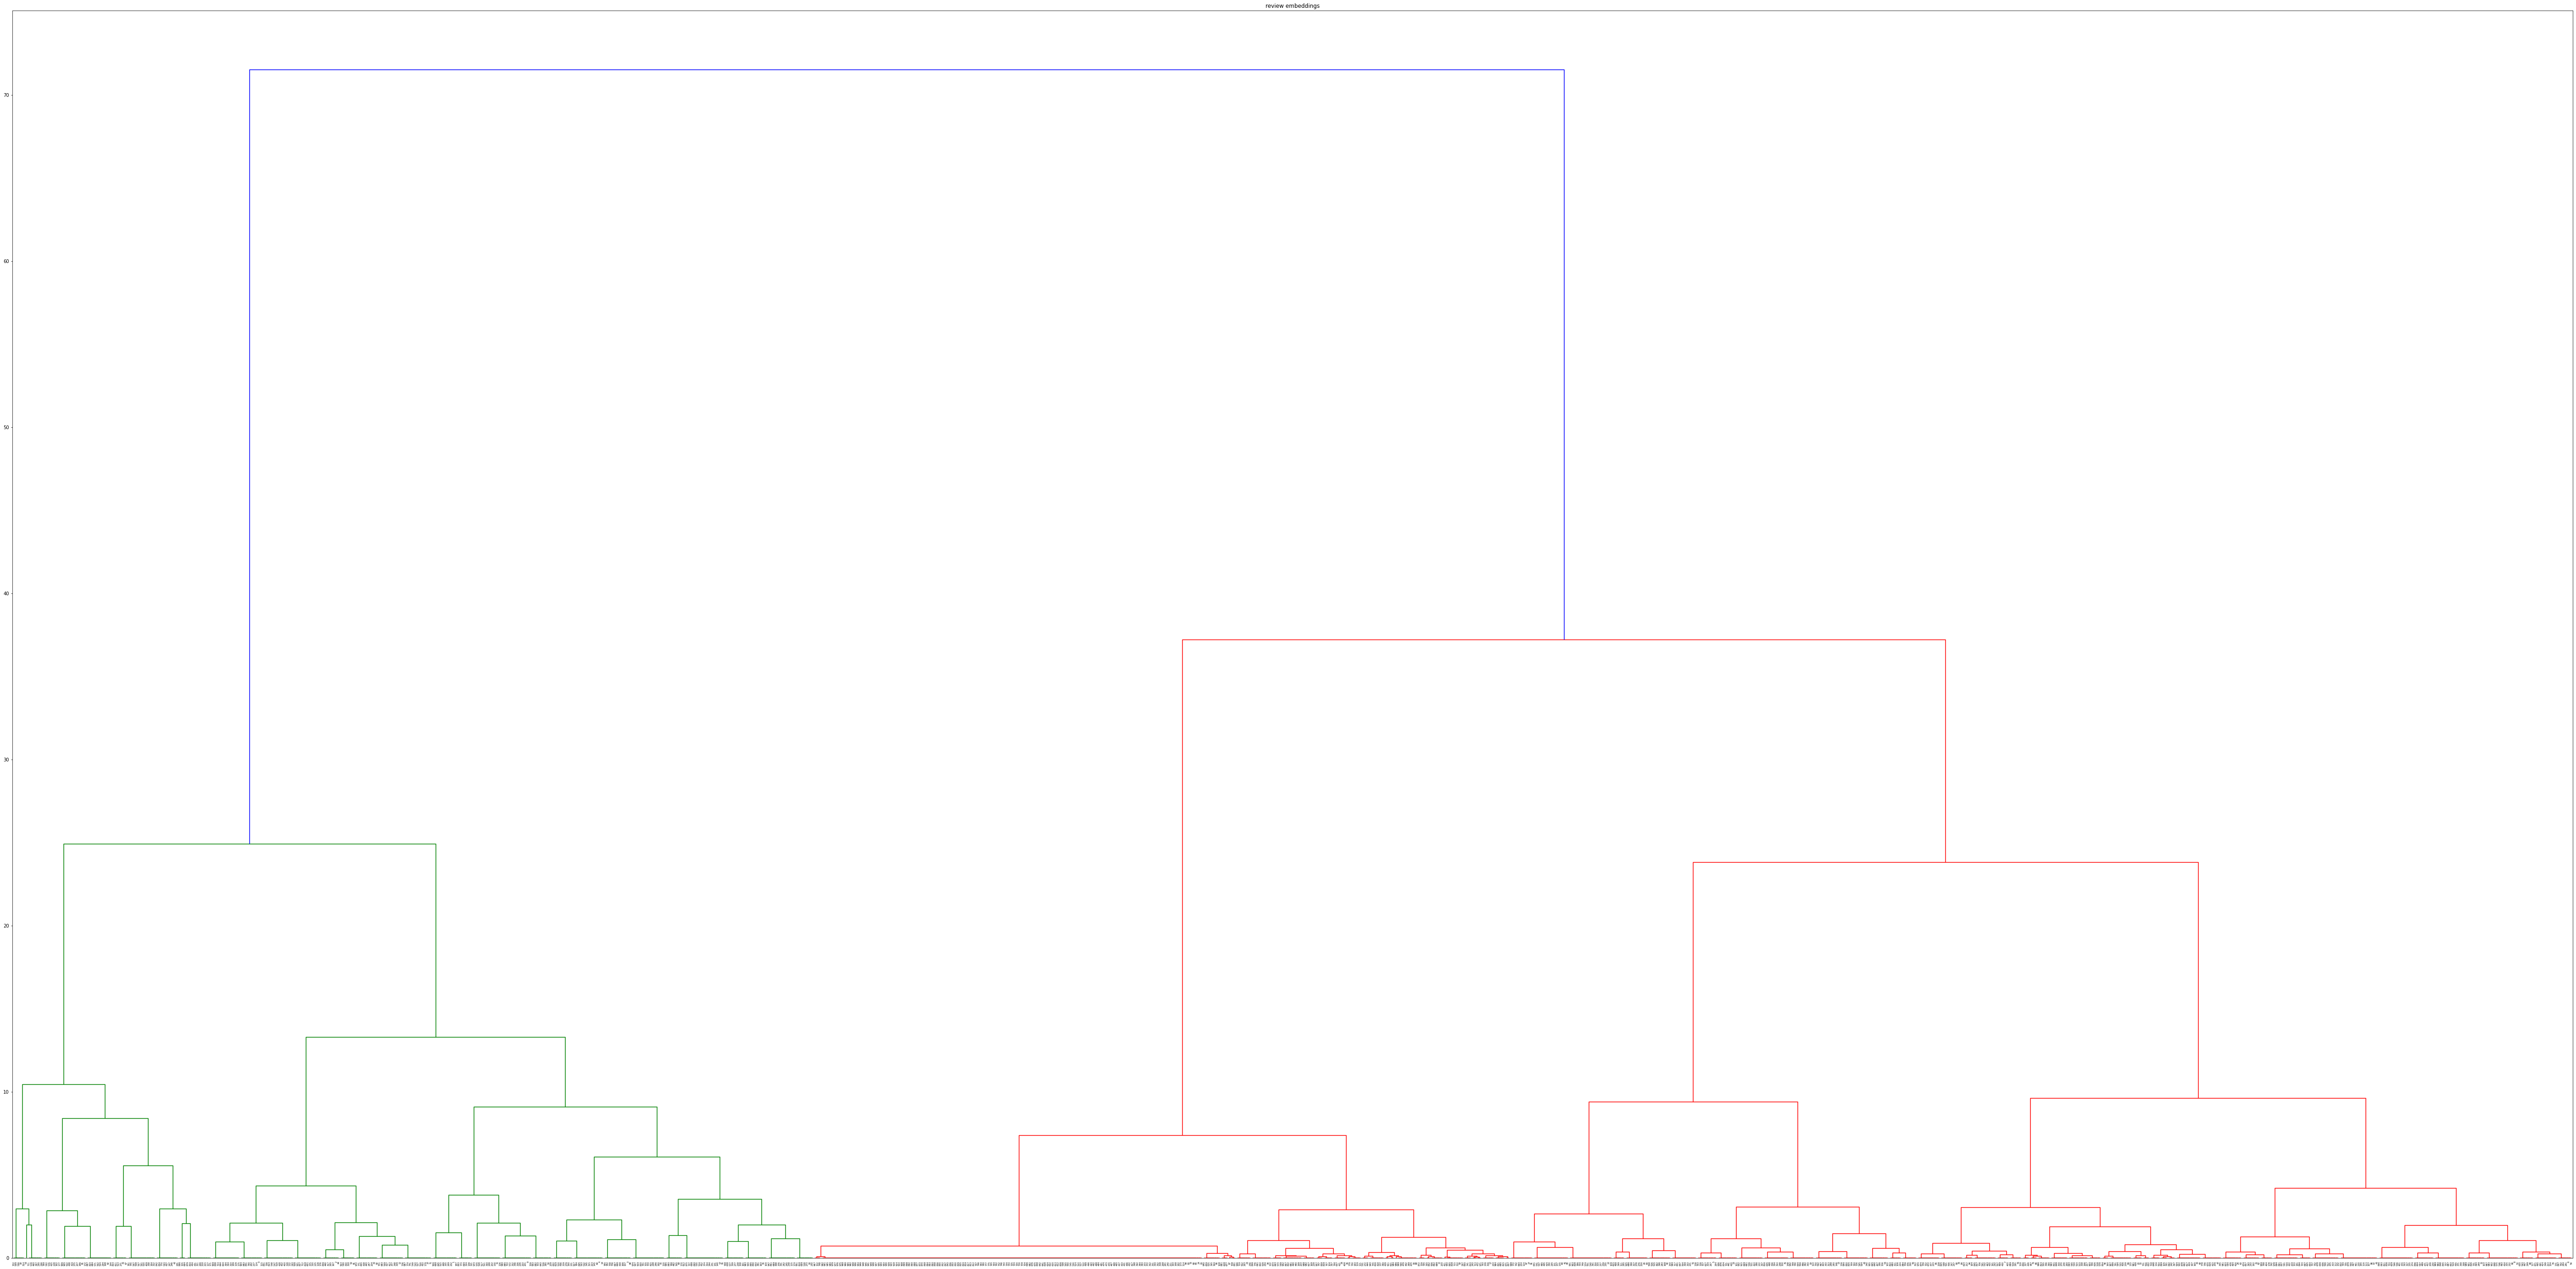

In [ ]:
# use the dendrogram graph to identify the clusters
import scipy.cluster.hierarchy as shc 
plt.figure(figsize = (100, 50))
plt.title("review embeddings")
dend = shc.dendrogram(shc.linkage(positive_embeddings, method = "ward"))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
cluster_id = cluster.fit_predict(positive_embeddings)

In [ ]:
sample_review = label_review.loc[label_review['label'] == 1,:].iloc[0:2000 ,:]
sample_review['cluster_id'] = cluster_id
sample_review

,text,label,cluster_id
0,This Columbia jacket is a pretty good quality ...,1,1
27,"Love Columbia jackets. However, the logo is pe...",1,1
56,This jacket fits perfectly. Size 2T. It has th...,1,1
101,We like Columbia rain jackets because they fol...,1,1
149,I like Columbia products because they are alwa...,1,1
...,...,...,...
111278,I had to contact Tech to finish installation a...,1,0
111286,The Norton 360 Deluxe - antivirus software was...,1,1
111298,"First, installation is a bit of a pain, only b...",1,0
111300,Norton products are great protection for all d...,1,1


In [ ]:
sample = sample_review.groupby('cluster_id').apply(pd.DataFrame.sample, 3).iloc[:,0]
sample.iloc[2]

'Love carhartt clothing. Extremely well made and rugged.'

In [ ]:
sample

cluster_id       
0           13893    Usual Carhartt ruggedness--looks to be durable...
            14294    Always trusted Carhartt and nothings changed. ...
            14240    Love carhartt clothing. Extremely well made an...
1           947      This is perfect for my son who likes to wear l...
            11654    I bought a black pair for $12, definitely wort...
            14137    I tried these due to some guys liking them. I'...
2           9754     Love it. Would recommend to others. I got anot...
            13936    Calhartt pants are my new pants since levi's d...
            14004    I love carhartt but I bought these jeans over ...
Name: text, dtype: object

In [ ]:
sample_review[sample_review['cluster_id']==2].sample()['text']

11608    I used to buy these shorts at Target for use a...
Name: text, dtype: object

In [ ]:
new_raw.iloc[13893,1]

'Usual Carhartt ruggedness--looks to be durable with good stitchery.'

In [ ]:
new_raw.iloc[14004,1]

'I love carhartt but I bought these jeans over a month ago and they were too tight I sent them back in and I still have yet to get my refund it was received back in January'

In [ ]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sample_review['polarity'] = sample_review['text'].apply(pol)
sample_review['subjectivity'] = sample_review['text'].apply(sub)
sample_review.head()

,text,label,cluster_id,polarity,subjectivity
0,This Columbia jacket is a pretty good quality ...,1,1,0.347222,0.488889
27,"Love Columbia jackets. However, the logo is pe...",1,1,0.250000,0.300000
56,This jacket fits perfectly. Size 2T. It has th...,1,1,0.518333,0.593333
101,We like Columbia rain jackets because they fol...,1,1,0.328889,0.497778
149,I like Columbia products because they are alwa...,1,1,0.233333,0.408333


In [ ]:
sample_review.groupby('cluster_id').mean()

,label,polarity,subjectivity
cluster_id,,,
0,1,0.170182,0.518238
1,1,0.313040,0.513335


In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
# things to be done
# 1. universal sentence encodning from Google
# 2. hierarchy clustering in python